In [10]:
RESULTS_FOLDER = './intermediate_results/new_models_probs'

import transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer, BertForMaskedLM, BertTokenizer, BartForConditionalGeneration, BartTokenizer

import os
from os.path import join, exists

os.chdir('/home/nwong/chompsky/serial_chain/telephone-analysis-public')

from new_models import prep_probs, model_score_funcs, model_score_utils, sub_analysis

import importlib
import load_runs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from collections import defaultdict


Checking whether right-side context is responsible for BERT "telephone" case

In [137]:


def get_attention_bert(raw_sentence, word, pos, mod, tok, pref):
    
    sentence = model_score_utils.prepSentence(raw_sentence)
    position = sub_analysis.find_true_token_position(sentence, word, pos, tok)

    # Note: above position is NOT with CLS added. This is accounted for in process_single_substitution. 

    if position == -2: return None
    # The desired token was probably fragmented by the tokenizer.
    # That is, the changed word couldn't be found in whole form after tokenization.

    position = position + 1
    # This is because CLS is not accounted for in the original index. This is for correctness of the prefixes.

    token_prefix, orig_tokens = pref(sentence, tok, [position])

    # Run the actual prediction

    this_input = torch.Tensor(token_prefix)
    with torch.no_grad():
        raw_outputs = mod(this_input.long().unsqueeze(0) if len(this_input.shape) == 1 else this_input.long(), output_attentions=True)
        attn = raw_outputs['attentions']
        
    return attn
        

In [139]:
# Because BERT so position = logit position

# CLS and SEP have high values that can "wash out" the differences in the word attentions.
# The same is true for "MASK"

def plot_bert_attentions(attn, tok, ground_truth_word, orig_tokens, attn_threshold = None, omit_cls_end_mask = False):

    if not omit_cls_end_mask:
        input_attn = torch.mean(attn[0][:, :, position, :], axis = 1)
        num_x_ticks = this_input.shape[1]
        display_words = token_words
    else:    
        input_attn = torch.mean(attn[0][:, :, position, 1:-1], axis = 1)
        num_x_ticks = this_input.shape[1] - 2
        display_words = this_token_words[1:-1]

    if attn_threshold is not None:
        input_attn = torch.clip(input_attn, 0, attn_threshold)


    # For text annotations and color bar
    # 6/2 : https://www.pythonprogramming.in/heatmap-with-intermediate-color-text-annotations.html

    fig, ax = plt.subplots(figsize=(10, 6))
    plt.title(f'Input attention activations for word: {ground_truth_word}, values clipped to 0.08')

    im = ax.imshow(input_attn, cmap = "YlGnBu")
    fig.colorbar(im)

    textcolors = ["k", "w"]

    #6/2 hide ticks: https://www.delftstack.com/howto/matplotlib/how-to-hide-axis-text-ticks-and-or-tick-labels-in-matplotlib/
    #6/2 rotation: https://www.delftstack.com/howto/matplotlib/how-to-rotate-x-axis-tick-label-text-in-matplotlib/
    #6/2 xtick text: https://www.mathworks.com/help/matlab/creating_plots/change-tick-marks-and-tick-labels-of-graph-1.html
    
    plt.yticks(color = 'w')
    plt.xticks(range(num_x_ticks), display_words, rotation = 45)
    threshold = 20/255
    for j in range(num_x_ticks):
        this_val = round(input_attn[0][j].item(), 3)
        ax.text(j, 0, this_val, ha="center", va="center", color=textcolors[this_val > threshold])

    # End taken code
    
    plt.show()


In [133]:
# To change the case that this is run on, change the below line:

def calc_and_plot_bert_attention(case_info, this_mod, this_tok, this_pref, attn_threshold = None):
    
    this_raw_sentence, this_word, this_pos = case_info
    
    this_token_prefix, this_orig_tokens = this_pref(this_sentence, this_tok, [this_pos])

    this_token_words = this_tok.convert_ids_to_tokens(this_token_prefix[0])
    this_ground_truth_word = this_tok.convert_ids_to_tokens([this_orig_tokens[this_pos]])[0]

    this_attn = get_attention_bert(this_raw_sentence, this_word, this_pos, this_mod, this_tok, this_pref)

    plot_bert_attentions(this_attn, this_tok, this_ground_truth_word, this_orig_tokens,
                         attn_threshold = attn_threshold, omit_cls_end_mask = False)
    

In [ ]:
bert_args = model_score_funcs.get_bert_modules()

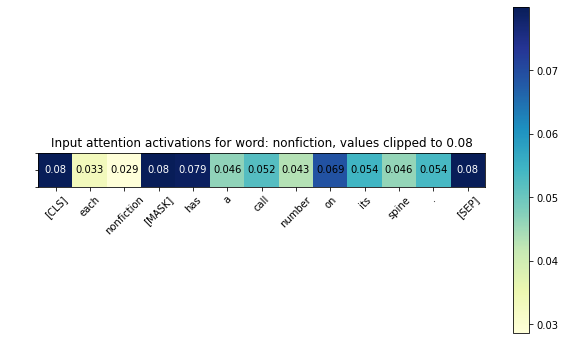

In [140]:
# attn_threshold: Manually chosen to be a little bit above the max attention after the CLS SEP and MASK, 0.079
book_phone_case = ("each nonfiction book has a call number on its spine", 'book', 2)
calc_and_plot_bert_attention(book_phone_case, *bert_args, 0.08)